Here it is an explanation on how did I smooth the Convoluted values of the SSS we obtained. 

The idea was to see if by avoiding big jumps in the SSS between the neighbouring points we would avoid the high peaks obtained in the wfcorr which appear in the regions between boxes. 

In [7]:
# read the packages that I use
import glob
import itertools
import math
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset # module to open netcdf
import os
import pylab
import sys  #module to get external varaibles
import scipy.signal
import time

# read the ORCA2 grid
loc="/data/igcmg/database/grids"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('ORCA2.3_grid.nc','r')
area = np.array(file2read1.variables['area'])
sys.path.insert(0, "/ccc/cont003/home/gen7403/estellav/Python/Tools")
import corr_VEP as corr
import Diags_VEP as Diags

In [8]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

Gilles_Grid = np.array([[-35. ,  -5. , -20. ,  -5. , -20. , -10. , -35. , -10. ],
       [-35. ,   4. , -20. ,   4. , -20. ,  -5. , -35. ,  -5. ],
       [-20. ,   0. ,  -0.1,   0. ,  -0.1, -10. , -20. , -10. ],
       [-50. ,  15. , -25. ,  15. , -25. ,   5. , -50. ,   5. ],
       [-75. ,  20. , -55. ,  20. , -55. ,  15. , -75. ,  15. ],
       [-55. ,  20. , -30. ,  20. , -30. ,  15. , -55. ,  15. ],
       [-30. ,  25. , -20. ,  25. , -20. ,  15. , -30. ,  15. ],
       [-20. ,  30. , -12. ,  30. , -17. ,  15. , -20. ,  15. ],
       [-47. ,  30. , -30. ,  30. , -30. ,  20. , -47. ,  20. ],
       [-55. ,  30. , -47. ,  30. , -47. ,  20. , -55. ,  20. ],
       [-75. ,  27. , -55. ,  27. , -55. ,  20. , -75. ,  20. ],
       [-75. ,  34. , -55. ,  34. , -55. ,  27. , -75. ,  27. ],
       [-73. ,  36. , -55. ,  36. , -55. ,  34. , -73. ,  34. ],
       [-55. ,  38. , -35. ,  38. , -35. ,  30. , -55. ,  30. ],
       [-35. ,  35. , -20. ,  35. , -20. ,  25. , -35. ,  25. ],
       [-20. ,  40. , -10. ,  40. , -10. ,  30. , -20. ,  30. ],
       [-40. ,  40. , -20. ,  40. , -20. ,  35. , -40. ,  35. ],
       [-40. ,  45. , -20. ,  45. , -20. ,  40. , -40. ,  40. ],
       [-20. ,  45. ,  -8. ,  45. ,  -8. ,  40. , -20. ,  40. ],
       [-40. ,  50. , -20. ,  50. , -20. ,  45. , -40. ,  45. ],
       [-20. ,  49. ,  -8. ,  49. ,  -8. ,  45. , -20. ,  45. ],
       [-70. ,  40. , -55. ,  40. , -55. ,  36. , -70. ,  36. ],
       [-55. ,  42. , -40. ,  42. , -40. ,  38. , -55. ,  38. ],
       [-45. ,   5. , -34. ,   5. , -34. ,  -3. , -45. ,  -3. ],
       [-36. , -10. , -25. , -10. , -25. , -20. , -36. , -20. ],
       [-10. , -10. ,  10. , -10. ,  10. , -20. , -10. , -20. ],
       [-45. ,  55. , -30. ,  55. , -30. ,  50. , -45. ,  50. ],
       [-30. ,  55. , -12. ,  55. , -12. ,  50. , -30. ,  50. ],
       [-15. ,  70. ,   5. ,  70. ,   5. ,  62. , -15. ,  62. ],
       [-24. ,  62. ,  -8. ,  62. ,  -8. ,  55. , -24. ,  55. ],
       [-40. ,  62. , -24. ,  62. , -24. ,  55. , -40. ,  55. ],
       [-56. ,  58.7, -45. ,  58.7, -45. ,  50. , -48. ,  50. ]])

loc="/data/igcmg/database/grids"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('ORCA2.3_grid.nc','r')
area = np.array(file2read1.variables['area'])
Aarea = np.concatenate((area[np.newaxis,:,: ], area[np.newaxis,:,: ]), axis=0)
for i in range(98):
    Aarea = np.concatenate((Aarea, area[np.newaxis,:,: ]), axis=0)
    
# features of the model I want to read

Models = []


Models.append({
              'name': 'CM5A2.1.pi.debug',
              'label':'CM5A2.1.pi.debug',
              'yr0':1001,
              'yr1':1501,
              'ts0':1000*12,
              'ts1':1500*12,
              'TS':'TS_MO',
              'maxamoc':[[]],
              'volicesum':[[]],
              'volicewint':[[]],
              'exticesum':[[]],
              'exticewint':[[]],
              'sstave':[[]],
              'annees':[[]],
              'color':'green',
              'ls':'-',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM5A2/DEVT/piControl/'})


# 1. Differences in the Input SSS

In [9]:

# get access to the model directory
dir1 = '/ccc/store/cont003/thredds/estellav/GillesData'
os.chdir(dir1)
# read the salinity variable
file1 = glob.glob('sosaline_All.nc')

f = Dataset(file1[0],'r')
# read the variables lat and lon
lon = np.array(f.variables['nav_lon'])
lat = np.array(f.variables['nav_lat'])
# read the salinity as a python array
tab=np.squeeze(f.variables['sos'][:,:,:])

# apply mask
mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
mask_zomsfatl[ma.where(tab==0)]=1.   

# apply the mask to the array
sss_complete=np.ma.array(tab, mask=mask_zomsfatl)




# read the salinity variable
file1 = glob.glob('sosaline_GillesAve_All.nc')

f = Dataset(file1[0],'r')
# read the variables lat and lon
lon = np.array(f.variables['nav_lon'])
lat = np.array(f.variables['nav_lat'])
# read the salinity as a python array
tab=np.squeeze(f.variables['sos'][:,:,:])

# apply mask
mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
mask_zomsfatl[ma.where(tab==0)]=1.   


# apply the mask to the array
sss_Gilles=np.ma.array(tab, mask=mask_zomsfatl)


# read the salinity variable
file1 = glob.glob('sosaline_Gilles_conv_SeasMean_All.nc')

f = Dataset(file1[0],'r')
# read the variables lat and lon
lon = np.array(f.variables['nav_lon'])
lat = np.array(f.variables['nav_lat'])
# read the salinity as a python array
tab=np.squeeze(f.variables['sos'][:,:,:])

# apply mask
mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))

mask_zomsfatl[ma.where(tab==0)]=1.   


# apply the mask to the array
sss_GillesConvoluted=np.ma.array(tab, mask=mask_zomsfatl)


/home/vestella/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/vestella/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


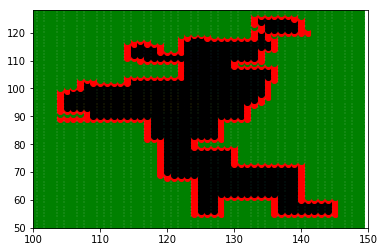

In [10]:
plt.contourf(sss_GillesConvoluted[0,:,:])
sss_smoothConv = ma.copy(sss_GillesConvoluted)
for i in range(100,150):
    for j in range(50,130):
        if (sss_GillesConvoluted.mask[0,j,i]==False)&(ma.any(sss_GillesConvoluted.mask[0,j-1:j+2,i-1:i+2])==False):      
            sss_smoothConv[:,j,i] = sss_GillesConvoluted[:,j,i]/2
            for i_add,j_add in itertools.product(np.arange(-1,1.1,1),np.arange(-1,1.1,1)):
                if (i_add!=0) or (j_add!=0):
                    sss_smoothConv[:,j,i] = sss_smoothConv[:,j,i] + sss_GillesConvoluted[:,j+j_add,i+i_add]/16
            plt.scatter(i,j, color='k')
        elif (sss_GillesConvoluted.mask[0,j,i]==False):
            sss_smoothConv[:,j,i] = sss_GillesConvoluted[:,j,i]
            plt.scatter(i,j, color='r')
        else:
            plt.scatter(i,j, color='g')
plt.xlim((100,150))
plt.ylim((50,128))
plt.show()

In this plot I am showing how I did the smoothing. From each grid point from the model withing the FDS mask, I considered only to smooth the ORCA2 gridpoints which were not located in the external boundaries of the mask (black points I smoothed, red I didn't and green were not considered within the loop). 

### I am checking If I am improving something by smoothing. 

In [12]:
dir1 = '/ccc/store/cont003/thredds/estellav/GillesData'
os.chdir(dir1)

file2read1 = Dataset('sosaline_GillesAve_All.nc','r')
lat = np.array(file2read1.variables['nav_lat'])
lon_2 = np.array(file2read1.variables['nav_lon'][:,100:145])
lat_2 = np.array(file2read1.variables['nav_lat'][:,100:145])
lon_1 = np.array(file2read1.variables['nav_lon'][100:140,110:145])
lat_1 = np.array(file2read1.variables['nav_lat'][100:140,110:145])

diff_Conv=ma.copy(sss_GillesConvoluted[:,:,:])*0
diff_SmoothConv=ma.copy(sss_GillesConvoluted[:,:,:])*0
diff_Target=ma.copy(sss_GillesConvoluted[:,:,:])*0
for i in range(100,150):
    for j in range(50,130):
        if (sss_GillesConvoluted.mask[0,j,i]==False)&(ma.any(sss_GillesConvoluted.mask[0,j-1:j+2,i-1:i+2])==False):      
            a = sss_GillesConvoluted[:,j,i]
            a_smooth = sss_smoothConv[:,j,i]
            a_target = sss_complete[:,j,i]
            b=0
            b_smooth=0
            b_target=0
            for i_add,j_add in itertools.product(np.arange(-1,1.1,1),np.arange(-1,1.1,1)):
                if (i_add!=0) or (j_add!=0):
                    b = b + sss_GillesConvoluted[:,j+j_add,i+i_add]/8
                    b_smooth = b_smooth + sss_smoothConv[:,j+j_add,i+i_add]/8
                    b_target = b_target + sss_complete[:,j+j_add,i+i_add]/8
            diff_Conv[:,j,i]=a-b
            diff_SmoothConv[:,j,i]=a_smooth-b_smooth
            diff_Target[:,j,i]=a_target-b_target
            


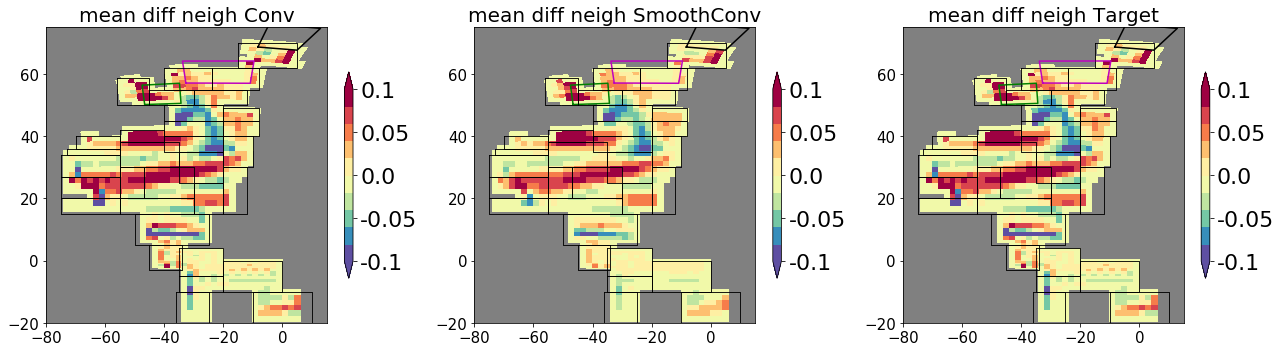

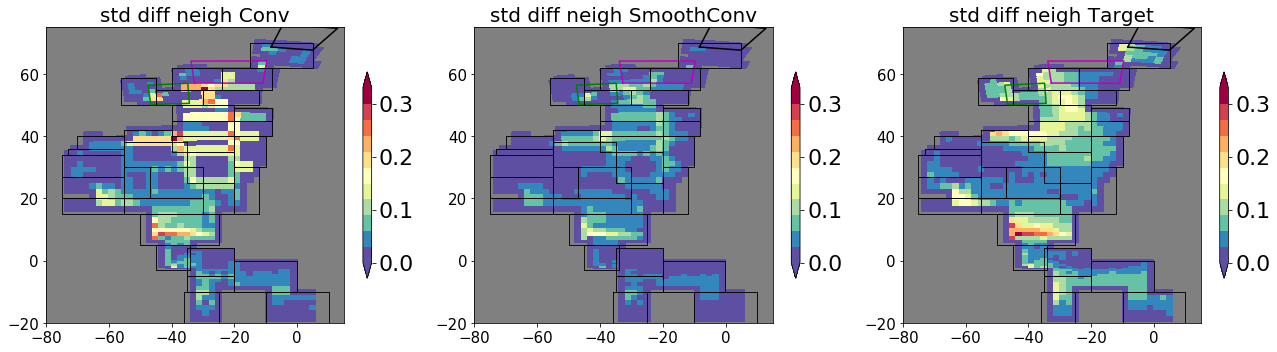

In [13]:
plt.close()
#create your figure
fig, axes = plt.subplots(1,3,figsize=(18,5))
# range of values for the colorbar
range_data = np.array(np.arange(-0.1,0.11,0.02))
ticks_data = np.array(np.arange(-0.1,0.11,0.05))
ticks_data[2]=0

levels = range_data#MaxNLocator(nbins=8).tick_values(ticks_data.min(), ticks_data.max())
# color scale of the plot
cmap = plt.cm.Spectral_r
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
for i in range(3):
    # chosen data
    if i==0:
        data2=diff_Conv[:,:,100:145]
        axes[i].set_title(r'mean diff neigh Conv' , fontsize=20)
    elif i==1:
        data2=diff_SmoothConv[:,:,100:145]
        axes[i].set_title(r'mean diff neigh SmoothConv' , fontsize=20)
    else:
        data2=diff_Target[:,:,100:145]
        axes[i].set_title(r'mean diff neigh Target' , fontsize=20)
    
    data = ma.mean(data2, axis=0)

    
    #background in grey
    axes[i].patch.set_facecolor('grey')
    #colormesh the data
    cs00=axes[i].pcolormesh( lon_2[:,:],lat_2[:,:], data[:,:],cmap=cmap, norm=norm)
    # plot the colorbar
    cb = plt.colorbar(cs00,extend='both',extendfrac='auto',ax=axes[i], shrink=.7, aspect=20)
    # features of the colorbar
    cb.set_ticks(ticks_data)
    cb.set_ticklabels(ticks_data)
    cb.ax.tick_params(labelsize=22)
    #control the size of the labels in the axes
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=15)

    axes[i].set_xlim((-80,15))
    axes[i].set_ylim((-20,75))

    #plot the convective regions in the model: Labrador Sea, South Iceland and Greenland Sea (Svalvard)
    axes[i].plot([lon[110,118],lon[110,124],lon[115,124],lon[115,118],lon[110,118]],
              [lat[110,118],lat[110,124],lat[115,124],lat[115,118],lat[110,118]], color='g', label = 'LS')
    axes[i].plot([lon[115,125],lon[115,135],lon[121,135],lon[121,125],lon[115,125]],
              [lat[115,125],lat[115,135],lat[121,135],lat[121,125],lat[115,125]],color='m', label = 'SI')
    axes[i].plot([lon[125,135],lon[125,140],lon[132,140],lon[132,135],lon[125,135]],
              [lat[125,135],lat[125,140],lat[132,140],lat[132,135],lat[125,135]],color='k', label = 'Sv')


    for l in range(32): # For each grid_box



        lat_bnds, lon_bnds = [Gilles_Grid[l,5], Gilles_Grid[l,3]], [Gilles_Grid[l,0], Gilles_Grid[l,2]]

        latss = [Gilles_Grid[l,3],Gilles_Grid[l,3], Gilles_Grid[l,5], Gilles_Grid[l,5],Gilles_Grid[l,3]]
        lonss = [Gilles_Grid[l,0], Gilles_Grid[l,2], Gilles_Grid[l,2],Gilles_Grid[l,0],Gilles_Grid[l,0]]


        # Variance explained
        axes[0].plot(lonss,latss, color ='k', lw=0.5 )
        axes[1].plot(lonss,latss, color ='k', lw=0.5 )
        axes[2].plot(lonss,latss, color ='k', lw=0.5 )



plt.tight_layout()    
plt.show() 

plt.close()
#create your figure
fig, axes = plt.subplots(1,3,figsize=(18,5))
# range of values for the colorbar
range_data = np.array(np.arange(0,0.33,0.03))
ticks_data = np.array(np.arange(0,0.31,0.1))


levels = range_data#MaxNLocator(nbins=8).tick_values(ticks_data.min(), ticks_data.max())
# color scale of the plot
cmap = plt.cm.Spectral_r
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
for i in range(3):
    # chosen data
    if i==0:
        data2=diff_Conv[:,:,100:145]
        axes[i].set_title(r'std diff neigh Conv' , fontsize=20)
    elif i==1:
        data2=diff_SmoothConv[:,:,100:145]
        axes[i].set_title(r'std diff neigh SmoothConv' , fontsize=20)
    else:
        data2=diff_Target[:,:,100:145]
        axes[i].set_title(r'std diff neigh Target' , fontsize=20)
    
    data = ma.std(data2, axis=0)

    
    #background in grey
    axes[i].patch.set_facecolor('grey')
    #colormesh the data
    cs00=axes[i].pcolormesh( lon_2[:,:],lat_2[:,:], data[:,:],cmap=cmap, norm=norm)
    # plot the colorbar
    cb = plt.colorbar(cs00,extend='both',extendfrac='auto',ax=axes[i], shrink=.7, aspect=20)
    # features of the colorbar
    cb.set_ticks(ticks_data)
    cb.set_ticklabels(ticks_data)
    cb.ax.tick_params(labelsize=22)
    #control the size of the labels in the axes
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=15)

    axes[i].set_xlim((-80,15))
    axes[i].set_ylim((-20,75))

    #plot the convective regions in the model: Labrador Sea, South Iceland and Greenland Sea (Svalvard)
    axes[i].plot([lon[110,118],lon[110,124],lon[115,124],lon[115,118],lon[110,118]],
              [lat[110,118],lat[110,124],lat[115,124],lat[115,118],lat[110,118]], color='g', label = 'LS')
    axes[i].plot([lon[115,125],lon[115,135],lon[121,135],lon[121,125],lon[115,125]],
              [lat[115,125],lat[115,135],lat[121,135],lat[121,125],lat[115,125]],color='m', label = 'SI')
    axes[i].plot([lon[125,135],lon[125,140],lon[132,140],lon[132,135],lon[125,135]],
              [lat[125,135],lat[125,140],lat[132,140],lat[132,135],lat[125,135]],color='k', label = 'Sv')


    for l in range(32): # For each grid_box



        lat_bnds, lon_bnds = [Gilles_Grid[l,5], Gilles_Grid[l,3]], [Gilles_Grid[l,0], Gilles_Grid[l,2]]

        latss = [Gilles_Grid[l,3],Gilles_Grid[l,3], Gilles_Grid[l,5], Gilles_Grid[l,5],Gilles_Grid[l,3]]
        lonss = [Gilles_Grid[l,0], Gilles_Grid[l,2], Gilles_Grid[l,2],Gilles_Grid[l,0],Gilles_Grid[l,0]]


        # Variance explained
        axes[0].plot(lonss,latss, color ='k', lw=0.5 )
        axes[1].plot(lonss,latss, color ='k', lw=0.5 )
        axes[2].plot(lonss,latss, color ='k', lw=0.5 )



plt.tight_layout()    
plt.show() 



Here I am showing the mean (top) and std of the difference of each ORCA2 gridpoint and the neighbouring ones. From left to right: Convoluted, Smooth Convoluted and Target (Full resolution)

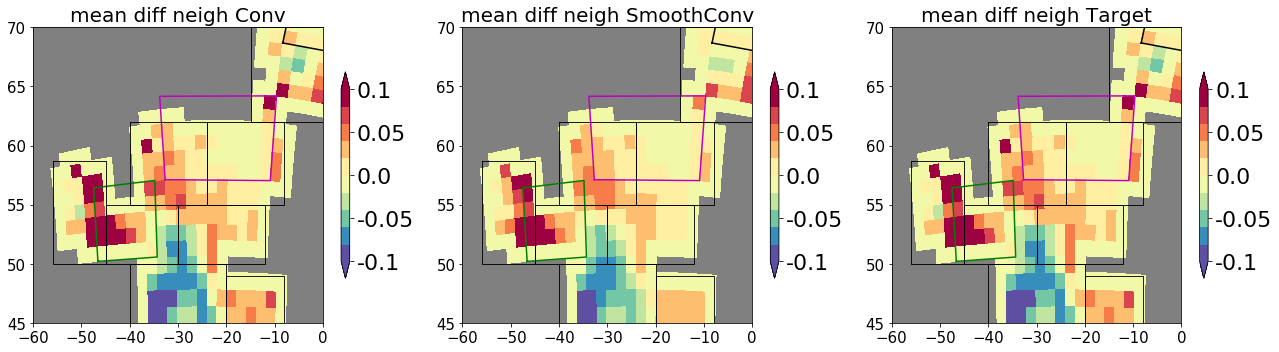

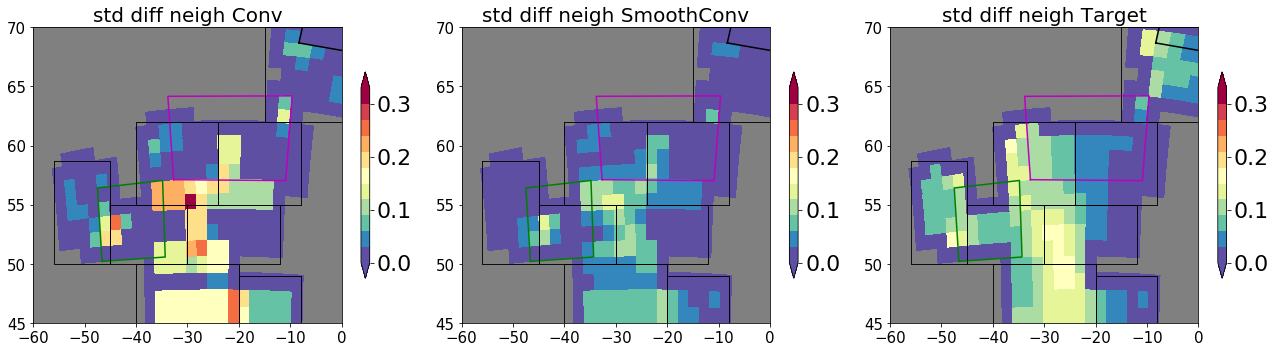

In [14]:
plt.close()
#create your figure
fig, axes = plt.subplots(1,3,figsize=(18,5))
# range of values for the colorbar
range_data = np.array(np.arange(-0.1,0.11,0.02))
ticks_data = np.array(np.arange(-0.1,0.11,0.05))
ticks_data[2]=0

levels = range_data#MaxNLocator(nbins=8).tick_values(ticks_data.min(), ticks_data.max())
# color scale of the plot
cmap = plt.cm.Spectral_r
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
for i in range(3):
    # chosen data
    if i==0:
        data2=diff_Conv[:,:,100:145]
        axes[i].set_title(r'mean diff neigh Conv' , fontsize=20)
    elif i==1:
        data2=diff_SmoothConv[:,:,100:145]
        axes[i].set_title(r'mean diff neigh SmoothConv' , fontsize=20)
    else:
        data2=diff_Target[:,:,100:145]
        axes[i].set_title(r'mean diff neigh Target' , fontsize=20)
    
    data = ma.mean(data2, axis=0)

    
    #background in grey
    axes[i].patch.set_facecolor('grey')
    #colormesh the data
    cs00=axes[i].pcolormesh( lon_2[:,:],lat_2[:,:], data[:,:],cmap=cmap, norm=norm)
    # plot the colorbar
    cb = plt.colorbar(cs00,extend='both',extendfrac='auto',ax=axes[i], shrink=.7, aspect=20)
    # features of the colorbar
    cb.set_ticks(ticks_data)
    cb.set_ticklabels(ticks_data)
    cb.ax.tick_params(labelsize=22)
    #control the size of the labels in the axes
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=15)

    axes[i].set_xlim((-60,0))
    axes[i].set_ylim((45,70))

    #plot the convective regions in the model: Labrador Sea, South Iceland and Greenland Sea (Svalvard)
    axes[i].plot([lon[110,118],lon[110,124],lon[115,124],lon[115,118],lon[110,118]],
              [lat[110,118],lat[110,124],lat[115,124],lat[115,118],lat[110,118]], color='g', label = 'LS')
    axes[i].plot([lon[115,125],lon[115,135],lon[121,135],lon[121,125],lon[115,125]],
              [lat[115,125],lat[115,135],lat[121,135],lat[121,125],lat[115,125]],color='m', label = 'SI')
    axes[i].plot([lon[125,135],lon[125,140],lon[132,140],lon[132,135],lon[125,135]],
              [lat[125,135],lat[125,140],lat[132,140],lat[132,135],lat[125,135]],color='k', label = 'Sv')


    for l in range(32): # For each grid_box



        lat_bnds, lon_bnds = [Gilles_Grid[l,5], Gilles_Grid[l,3]], [Gilles_Grid[l,0], Gilles_Grid[l,2]]

        latss = [Gilles_Grid[l,3],Gilles_Grid[l,3], Gilles_Grid[l,5], Gilles_Grid[l,5],Gilles_Grid[l,3]]
        lonss = [Gilles_Grid[l,0], Gilles_Grid[l,2], Gilles_Grid[l,2],Gilles_Grid[l,0],Gilles_Grid[l,0]]


        # Variance explained
        axes[0].plot(lonss,latss, color ='k', lw=0.5 )
        axes[1].plot(lonss,latss, color ='k', lw=0.5 )
        axes[2].plot(lonss,latss, color ='k', lw=0.5 )



plt.tight_layout()    
plt.show() 

plt.close()
#create your figure
fig, axes = plt.subplots(1,3,figsize=(18,5))
# range of values for the colorbar
range_data = np.array(np.arange(0,0.33,0.03))
ticks_data = np.array(np.arange(0,0.31,0.1))


levels = range_data#MaxNLocator(nbins=8).tick_values(ticks_data.min(), ticks_data.max())
# color scale of the plot
cmap = plt.cm.Spectral_r
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
for i in range(3):
    # chosen data
    if i==0:
        data2=diff_Conv[:,:,100:145]
        axes[i].set_title(r'std diff neigh Conv' , fontsize=20)
    elif i==1:
        data2=diff_SmoothConv[:,:,100:145]
        axes[i].set_title(r'std diff neigh SmoothConv' , fontsize=20)
    else:
        data2=diff_Target[:,:,100:145]
        axes[i].set_title(r'std diff neigh Target' , fontsize=20)
    
    data = ma.std(data2, axis=0)

    
    #background in grey
    axes[i].patch.set_facecolor('grey')
    #colormesh the data
    cs00=axes[i].pcolormesh( lon_2[:,:],lat_2[:,:], data[:,:],cmap=cmap, norm=norm)
    # plot the colorbar
    cb = plt.colorbar(cs00,extend='both',extendfrac='auto',ax=axes[i], shrink=.7, aspect=20)
    # features of the colorbar
    cb.set_ticks(ticks_data)
    cb.set_ticklabels(ticks_data)
    cb.ax.tick_params(labelsize=22)
    #control the size of the labels in the axes
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=15)

    axes[i].set_xlim((-60,0))
    axes[i].set_ylim((45,70))

    #plot the convective regions in the model: Labrador Sea, South Iceland and Greenland Sea (Svalvard)
    axes[i].plot([lon[110,118],lon[110,124],lon[115,124],lon[115,118],lon[110,118]],
              [lat[110,118],lat[110,124],lat[115,124],lat[115,118],lat[110,118]], color='g', label = 'LS')
    axes[i].plot([lon[115,125],lon[115,135],lon[121,135],lon[121,125],lon[115,125]],
              [lat[115,125],lat[115,135],lat[121,135],lat[121,125],lat[115,125]],color='m', label = 'SI')
    axes[i].plot([lon[125,135],lon[125,140],lon[132,140],lon[132,135],lon[125,135]],
              [lat[125,135],lat[125,140],lat[132,140],lat[132,135],lat[125,135]],color='k', label = 'Sv')


    for l in range(32): # For each grid_box



        lat_bnds, lon_bnds = [Gilles_Grid[l,5], Gilles_Grid[l,3]], [Gilles_Grid[l,0], Gilles_Grid[l,2]]

        latss = [Gilles_Grid[l,3],Gilles_Grid[l,3], Gilles_Grid[l,5], Gilles_Grid[l,5],Gilles_Grid[l,3]]
        lonss = [Gilles_Grid[l,0], Gilles_Grid[l,2], Gilles_Grid[l,2],Gilles_Grid[l,0],Gilles_Grid[l,0]]


        # Variance explained
        axes[0].plot(lonss,latss, color ='k', lw=0.5 )
        axes[1].plot(lonss,latss, color ='k', lw=0.5 )
        axes[2].plot(lonss,latss, color ='k', lw=0.5 )



plt.tight_layout()    
plt.show() 



Same as before but looking at the SPG: the mean (top) and std of the difference of each ORCA2 gridpoint and the neighbouring ones. From left to right: Convoluted, Smooth Convoluted and Target (Full resolution)

-> we can see that in fact that some anomalies between neighbouring points in the Convoluted (left panels) are related with the limits of the Gilles mask boxes. 

# 2. Results